In [1]:
import datetime
import numpy as np 
import time
import re
from datetime import datetime
import pickle
import string
import pandas as pd
from copy import deepcopy
import operator
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import urllib.request
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# aux functions

In [3]:
def get_pe_ratio(soup_tag):
    
    pe_ratio = float(str(soup_tag[0]).split("<")[1].split(">")[-1])
    print("P/E ratio", pe_ratio)
    
    return pe_ratio
    
def get_short_float(soup_tag):
    
    short_float = float(str(soup_tag[-1]).split("<")[1].split(">")[-1][:-1])
    print("Short interest", short_float)
    
    return short_float

def get_prices(list_tag):
    
    current = float(".".join(re.findall(r'\d+', str(list_tag[-1]))))
    median_estimate = float(".".join(re.findall(r'\d+', str(list_tag[-4]))))
    low_estimate = float(".".join(re.findall(r'\d+', str(list_tag[-3]))))
    high_estimate = float(".".join(re.findall(r'\d+', str(list_tag[-5]))))
    
    median_change = ((median_estimate-current)/current)*100
    high_change = ((high_estimate-current)/current)*100
    low_change = ((low_estimate-current)/current)*100
    
    return median_change, high_change, low_change, current

def get_num_analysts(list_tag):
    
    num_analyst_list = list_tag[7:-5]
    num_analyst_list = [num_analyst_list[2+index*3] for index in range(int(len(num_analyst_list)/3))]
    n_analysts = np.sum([int(re.findall(r'\d+', str(string_analyst))[0]) for string_analyst in num_analyst_list])

    return n_analysts

def get_industry(soup_tag):
    
    industry = str(soup_tag[1]).split(",")[5].split("\"")[3]
    
    return industry
    

# fetch company names and price

In [4]:
def get_nyse_stocks():
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}

    list_stock = []
    for letter in string.ascii_uppercase:
        print("Fetching for letter: " + letter)
        
        r = requests.get("https://eoddata.com/stocklist/NYSE/" + letter + ".htm", headers=headers)
        html_doc = r.text
        soup = BeautifulSoup(html_doc, 'html.parser')
        soup_tag = soup.find_all("a", href=True)

        for link in soup_tag:
            text = link.get('href')
            if "/stockquote/NYSE/" in text:
                text = text.split("/")[-1].split(".")[0]

                if text not in list_stock:
                    list_stock.append(text)
                    
    return list_stock

In [5]:
def get_interesting_stocks(list_stock):
    
    interesting_stocks = dict()
    database = dict()
    
    for symbol in list_stock:
        
        print(symbol)

        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}
        
        full_data = True
        try:
            r = requests.get("https://www.wsj.com/market-data/quotes/" + symbol + "/research-ratings", headers=headers)
            html_doc = r.text
            soup = BeautifulSoup(html_doc, 'html.parser')
            soup_tag_price = soup.find_all("span", attrs={"class": "data_data"})
            
            num_analysts = get_num_analysts(soup_tag_price)
            
            median_change, high_change, low_change, current = get_prices(soup_tag_price)
            if low_change > 0 and num_analysts >= 6:
                interesting_stocks[symbol] = low_change
            
        except (ValueError, IndexError, ZeroDivisionError): 
            print("No data found for symbol: " + symbol)
            full_data = False
            
        if full_data:
            
            r = requests.get("https://www.wsj.com/market-data/quotes/" + symbol, headers=headers)
            html_doc = r.text
            soup = BeautifulSoup(html_doc, 'html.parser')
            soup_tag_overview = soup.find_all("span", attrs={"class": "WSJTheme--data_data--3CZkJ3RI"})

            try:
                short_float = get_short_float(soup_tag_overview)
            except (ValueError, IndexError):
                full_data = False
                print("No short float data found")
                
            try:
                pe_ratio = get_pe_ratio(soup_tag_overview)
            except (ValueError, IndexError):
                if full_data:
                    pe_ratio = 0.0
                else:
                    full_data = False
                print("No P/E data found")
                
        if full_data:
            database[symbol] = [pe_ratio, short_float, median_change, high_change, low_change, current, num_analysts]

    return interesting_stocks, database

In [6]:
def scrap_zacks(interesting_stocks, database, symbol):
    
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}
        r = requests.get("https://www.zacks.com/stock/quote/" + symbol + "?q=aapl", headers=headers, timeout=60)
        html_doc = r.text
        soup = BeautifulSoup(html_doc, 'html.parser')
        
        soup_tag_rank = soup.find_all("p",  attrs={"class": "rank_view"})
        soup_tag = soup.find_all("span", attrs={"class": "composite_val"})
        soup_tag_industry = soup.find_all("script", attrs={"type": "application/ld+json"})
        
        try:
            if len(soup_tag) == 8:
                soup_tag = soup_tag[-4:-1]
                score_list = [char for tag in soup_tag for char in str(tag) if char.isupper()]
                buy_reccomendation = re.findall(r'\d+', str(soup_tag_rank).split("<")[1])
                industry = get_industry(soup_tag_industry)
                
                if score_list:
                    score_list.sort()
                    if score_list[-1] <= 'B' and symbol in interesting_stocks.keys():
                        potential_upside = interesting_stocks[symbol]
                        interesting_stocks[symbol] = [potential_upside, score_list, buy_reccomendation, industry]
                        
                database[symbol] = database[symbol] + [score_list, buy_reccomendation]
                print(symbol, database[symbol])
                
            else:
                print("No data found for symbol: " + symbol)
                
        except IndexError:
            print("No data found for symbol: " + symbol)
            
        return interesting_stocks, database

In [7]:
def get_interesting_stocks_zacks(interesting_stocks, database):
    
    for symbol in database.keys():
        time.sleep(0.01)
        
        try:
            interesting_stocks, database = scrap_zacks(interesting_stocks, database, symbol)    
        except (requests.exceptions.RequestException, ValueError) as e:
            print("caught", e, symbol)
            interesting_stocks, database = scrap_zacks(interesting_stocks, database, symbol)
    
    return interesting_stocks, database
            

In [8]:
list_stock = get_nyse_stocks()

Fetching for letter: A
Fetching for letter: B
Fetching for letter: C
Fetching for letter: D
Fetching for letter: E
Fetching for letter: F
Fetching for letter: G
Fetching for letter: H
Fetching for letter: I
Fetching for letter: J
Fetching for letter: K
Fetching for letter: L
Fetching for letter: M
Fetching for letter: N
Fetching for letter: O
Fetching for letter: P
Fetching for letter: Q
Fetching for letter: R
Fetching for letter: S
Fetching for letter: T
Fetching for letter: U
Fetching for letter: V
Fetching for letter: W
Fetching for letter: X
Fetching for letter: Y
Fetching for letter: Z


# find value stocks

In [33]:
interesting_stocks, database = get_interesting_stocks(list_stock)

A
Short interest 1.14
P/E ratio 48.56
AA
Short interest 6.59
P/E ratio 21.95
AAC
No data found for symbol: AAC
AAI-B
No data found for symbol: AAI-B
AAI-C
No data found for symbol: AAI-C
AAIC
Short interest 0.88
No P/E data found
AAIN
No short float data found
No P/E data found
AAN
Short interest 2.22
P/E ratio 10.26
AAP
Short interest 6.31
P/E ratio 22.29
AAQ
No data found for symbol: AAQ
AAQC
No data found for symbol: AAQC
AAT
Short interest 2.54
P/E ratio 126.24
AB
Short interest 1.44
P/E ratio 15.31
ABB
Short interest 0.11
P/E ratio 12.14
ABBV
Short interest 0.74
P/E ratio 29.38
ABC
Short interest 1.14
No P/E data found
ABEV
No short float data found
P/E ratio 16.3
ABG
Short interest 7.58
P/E ratio 8.93
ABM
Short interest 2.18
P/E ratio 21.89
ABR
Short interest 3.67
P/E ratio 7.32
ABR-D
No data found for symbol: ABR-D
ABR-E
No data found for symbol: ABR-E
ABT
Short interest 0.63
P/E ratio 32.94
AC
No data found for symbol: AC
ACA
Short interest 2.9
P/E ratio 32.02
ACC
Short interes

Short interest 0.96
P/E ratio 41.69
AQN
Short interest 2.43
P/E ratio 13.18
AQNA
No short float data found
No P/E data found
AQNB
No short float data found
No P/E data found
AQNU
No data found for symbol: AQNU
AQUA
Short interest 1.79
P/E ratio 82.59
AR
No data found for symbol: AR
ARC
Short interest 1.41
P/E ratio 17.2
ARCH
Short interest 23.85
No P/E data found
ARCO
No data found for symbol: ARCO
ARD
No data found for symbol: ARD
ARDC
No data found for symbol: ARDC
ARE
No data found for symbol: ARE
ARES
Short interest 0.97
P/E ratio 42.21
ARG-A
No data found for symbol: ARG-A
ARGD
No data found for symbol: ARGD
ARGO
No data found for symbol: ARGO
ARI
Short interest 1.35
P/E ratio 11.35
ARL
No data found for symbol: ARL
ARLO
No data found for symbol: ARLO
ARMK
Short interest 4.07
No P/E data found
ARNC
Short interest 4.4
No P/E data found
AROC
No data found for symbol: AROC
ARR
Short interest 5.3
P/E ratio 5.09
ARR-C
No data found for symbol: ARR-C
ARW
Short interest 2.26
P/E ratio 10

Short interest 2.94
No P/E data found
BIPH
No data found for symbol: BIPH
BIT
No data found for symbol: BIT
BITE
No data found for symbol: BITE
BJ
Short interest 6.63
P/E ratio 17.96
BK
Short interest 0.97
P/E ratio 13.68
BKD
Short interest 5.1
No P/E data found
BKE
Short interest 16.93
P/E ratio 9.24
BKH
Short interest 2.1
P/E ratio 16.85
BKI
Short interest 1.66
P/E ratio 44.08
BKN
No data found for symbol: BKN
BKR
Short interest 2.63
No P/E data found
BKS
No data found for symbol: BKS
BKSY
Short interest 3.7
No P/E data found
BKT
No data found for symbol: BKT
BKU
Short interest 2.33
P/E ratio 11.6
BLD
Short interest 2.39
P/E ratio 23.57
BLDR
Short interest 4.37
P/E ratio 10.34
BLE
No data found for symbol: BLE
BLK
No data found for symbol: BLK
BLL
Short interest 3.23
P/E ratio 34.43
BLND
No data found for symbol: BLND
BLU
Short interest 3.8
No P/E data found
BLUA
No data found for symbol: BLUA
BLW
No data found for symbol: BLW
BLX
Short interest 1.39
P/E ratio 12.23
BMA
Short interes

Short interest 1.33
P/E ratio 38.27
CIEN
Short interest 2.76
P/E ratio 17.73
CIF
No data found for symbol: CIF
CIG
Short interest 0.19
P/E ratio 5.34
CII
No data found for symbol: CII
CIM
Short interest 4.21
P/E ratio 5.0
CIM-A
No data found for symbol: CIM-A
CIM-B
No data found for symbol: CIM-B
CIM-C
No data found for symbol: CIM-C
CIM-D
No data found for symbol: CIM-D
CINR
Short interest 0.12
P/E ratio 22.33
CIO
Short interest 2.3
P/E ratio 17.39
CIO-A
No data found for symbol: CIO-A
CIR
Short interest 2.29
No P/E data found
CIT
Short interest 5.09
P/E ratio 8.93
CIT-B
No data found for symbol: CIT-B
CIXX
Short interest 0.13
P/E ratio 11.48
CL
Short interest 0.98
P/E ratio 23.68
CLA
No data found for symbol: CLA
CLAA
No data found for symbol: CLAA
CLAS
No data found for symbol: CLAS
CLB
Short interest 7.8
P/E ratio 40.66
CLBR
No data found for symbol: CLBR
CLD-A
No data found for symbol: CLD-A
CLDR
Short interest 5.34
No P/E data found
CLDT
Short interest 2.16
No P/E data found
CLF


No data found for symbol: DBL
DBR-H
No data found for symbol: DBR-H
DBR-I
No data found for symbol: DBR-I
DBR-J
No data found for symbol: DBR-J
DBRG
Short interest 12.42
No P/E data found
DCF
No data found for symbol: DCF
DCI
Short interest 0.91
P/E ratio 26.19
DCO
Short interest 1.88
P/E ratio 19.91
DCP
Short interest 4.22
P/E ratio 38.95
DCP-B
No data found for symbol: DCP-B
DCP-C
No data found for symbol: DCP-C
DCUE
No short float data found
No P/E data found
DD
Short interest 1.2
P/E ratio 6.92
DDD
Short interest 9.71
No P/E data found
DDF
No data found for symbol: DDF
DDL
Short interest 0.16
No P/E data found
DDS
Short interest 10.36
P/E ratio 8.55
DDT
No data found for symbol: DDT
DE
Short interest 0.96
P/E ratio 19.83
DEA
Short interest 12.9
P/E ratio 80.67
DECK
Short interest 3.66
P/E ratio 23.62
DEH
No data found for symbol: DEH
DEI
Short interest 6.12
P/E ratio 116.41
DELL
Short interest 3.1
P/E ratio 21.88
DEN
Short interest 7.49
No P/E data found
DEO
Short interest 0.06
P/E

Short interest 6.69
P/E ratio 21.67
EPD
Short interest 2.37
P/E ratio 12.52
EPR
Short interest 3.09
No P/E data found
EPR-C
No data found for symbol: EPR-C
EPR-E
No data found for symbol: EPR-E
EPR-G
No data found for symbol: EPR-G
EPRT
Short interest 2.37
P/E ratio 373.06
EPW
No data found for symbol: EPW
EPWR
No data found for symbol: EPWR
EQC
Short interest 3.89
No P/E data found
EQC-D
No data found for symbol: EQC-D
EQD
No data found for symbol: EQD
EQH
Short interest 1.72
No P/E data found
EQH-A
No data found for symbol: EQH-A
EQH-C
No data found for symbol: EQH-C
EQHA
No data found for symbol: EQHA
EQNR
Short interest 0.19
No P/E data found
EQR
Short interest 1.71
P/E ratio 45.38
EQS
No data found for symbol: EQS
EQT
Short interest 5.78
No P/E data found
ERF
Short interest 1.16
No P/E data found
ERJ
Short interest 2.33
No P/E data found
ERO
Short interest 0.86
P/E ratio 7.7
ES
Short interest 1.17
P/E ratio 22.55
ESE
Short interest 1.3
P/E ratio 89.62
ESGC
Short interest 11.48
No 

No data found for symbol: GAB-G
GAB-H
No data found for symbol: GAB-H
GAB-J
No data found for symbol: GAB-J
GAB-K
No data found for symbol: GAB-K
GAM
No data found for symbol: GAM
GAM-B
No data found for symbol: GAM-B
GAP
No data found for symbol: GAP
GAPA
No data found for symbol: GAPA
GATO
Short interest 4.73
P/E ratio 627.87
GATX
Short interest 9.97
P/E ratio 30.23
GB
No data found for symbol: GB
GBAB
No data found for symbol: GBAB
GBL
Short interest 1.12
P/E ratio 10.18
GBX
Short interest 13.06
No P/E data found
GCI
Short interest 11.79
No P/E data found
GCO
Short interest 5.62
P/E ratio 7.42
GCP
Short interest 1.36
P/E ratio 14.63
GCV
No data found for symbol: GCV
GD
Short interest 0.88
P/E ratio 17.25
GDDY
Short interest 2.86
P/E ratio 63.89
GDL
No data found for symbol: GDL
GDL-C
No data found for symbol: GDL-C
GDO
No data found for symbol: GDO
GDOT
Short interest 5.82
P/E ratio 127.02
GDV
No data found for symbol: GDV
GDV-G
No data found for symbol: GDV-G
GDV-H
No data found fo

Short interest 7.58
P/E ratio 1.13
HP
Short interest 6.67
No P/E data found
HPE
Short interest 2.82
P/E ratio 18.81
HPF
No data found for symbol: HPF
HPI
No data found for symbol: HPI
HPP
Short interest 3.89
No P/E data found
HPQ
Short interest 4.07
P/E ratio 8.7
HPS
No data found for symbol: HPS
HPX
No data found for symbol: HPX
HQH
No data found for symbol: HQH
HQL
No data found for symbol: HQL
HR
Short interest 3.59
P/E ratio 113.91
HRB
Short interest 7.22
P/E ratio 8.04
HRC
Short interest 1.92
P/E ratio 42.29
HRI
Short interest 2.59
P/E ratio 33.01
HRL
Short interest 5.33
P/E ratio 26.0
HRTG
Short interest 2.12
No P/E data found
HSBC
Short interest 0.14
P/E ratio 11.67
HSC
Short interest 3.98
No P/E data found
HSY
Short interest 1.57
P/E ratio 24.83
HT
Short interest 3.05
No P/E data found
HT-C
No data found for symbol: HT-C
HT-D
No data found for symbol: HT-D
HT-E
No data found for symbol: HT-E
HTA
Short interest 7.32
P/E ratio 81.99
HTD
No data found for symbol: HTD
HTFB
No short

No data found for symbol: KAHC
KAI
Short interest 1.65
P/E ratio 34.1
KAMN
Short interest 2.48
No P/E data found
KAR
Short interest 9.37
P/E ratio 57.96
KB
Short interest 0.15
P/E ratio 5.09
KBH
Short interest 5.35
P/E ratio 7.42
KBR
Short interest 6.79
No P/E data found
KCA
No data found for symbol: KCA
KCAC
No data found for symbol: KCAC
KCG
No data found for symbol: KCG
KEN
No data found for symbol: KEN
KEP
Short interest 0.07
P/E ratio 12.81
KEX
Short interest 1.97
P/E ratio 51.85
KEY
Short interest 6.22
P/E ratio 9.63
KEY-I
No data found for symbol: KEY-I
KEY-J
No data found for symbol: KEY-J
KEY-K
No data found for symbol: KEY-K
KEYS
Short interest 3.01
P/E ratio 37.35
KF
No data found for symbol: KF
KFS
Short interest 0.07
No P/E data found
KFY
Short interest 1.34
P/E ratio 18.57
KGC
Short interest 0.97
P/E ratio 5.21
KIM
Short interest 3.76
P/E ratio 24.01
KIM-L
No data found for symbol: KIM-L
KIM-M
No data found for symbol: KIM-M
KIO
No data found for symbol: KIO
KKR
Short int

No data found for symbol: MGRD
MGU
No data found for symbol: MGU
MGY
Short interest 10.56
P/E ratio 17.32
MH-A
No data found for symbol: MH-A
MH-C
No data found for symbol: MH-C
MH-D
No data found for symbol: MH-D
MHD
No data found for symbol: MHD
MHF
No data found for symbol: MHF
MHI
No data found for symbol: MHI
MHK
Short interest 2.67
P/E ratio 12.33
MHLA
No data found for symbol: MHLA
MHN
No data found for symbol: MHN
MHNC
No data found for symbol: MHNC
MHO
Short interest 3.73
P/E ratio 4.97
MIC
Short interest 6.5
No P/E data found
MIN
No data found for symbol: MIN
MIO
No data found for symbol: MIO
MIT
No data found for symbol: MIT
MIT-A
No data found for symbol: MIT-A
MIT-B
No data found for symbol: MIT-B
MIT-C
No data found for symbol: MIT-C
MITT
Short interest 0.91
P/E ratio 1.55
MIXT
Short interest 0.22
P/E ratio 19.11
MIY
No data found for symbol: MIY
MKC
Short interest 1.68
P/E ratio 28.72
MKF
No data found for symbol: MKF
MKFG
Short interest 1.08
No P/E data found
MKL
No dat

No data found for symbol: NMS
NMT
No data found for symbol: NMT
NMZ
No data found for symbol: NMZ
NNA
Short interest 1.46
No P/E data found
NNI
Short interest 1.03
P/E ratio 6.25
NNN
Short interest 2.55
P/E ratio 33.88
NNN-F
No data found for symbol: NNN-F
NNY
No data found for symbol: NNY
NOA
Short interest 1.01
P/E ratio 15.28
NOAH
Short interest 2.68
No P/E data found
NOC
Short interest 1.11
P/E ratio 13.02
NOK
Short interest 0.61
No P/E data found
NOM
No data found for symbol: NOM
NOMD
Short interest 1.46
P/E ratio 20.55
NOV
Short interest 3.73
No P/E data found
NOVA
Short interest 14.51
No P/E data found
NOW
Short interest 1.74
P/E ratio 750.65
NP
Short interest 1.81
No P/E data found
NPCT
No data found for symbol: NPCT
NPK
Short interest 2.86
P/E ratio 13.24
NPO
Short interest 1.06
P/E ratio 112.93
NPTN
Short interest 2.6
No P/E data found
NPV
No data found for symbol: NPV
NQP
No data found for symbol: NQP
NR
Short interest 2.0
No P/E data found
NRD
No data found for symbol: NRD


Short interest 4.72
P/E ratio 634.1
PEO
No data found for symbol: PEO
PFD
No data found for symbol: PFD
PFE
Short interest 0.97
P/E ratio 18.38
PFGC
Short interest 5.39
P/E ratio 160.82
PFH
No short float data found
No P/E data found
PFL
No data found for symbol: PFL
PFN
No data found for symbol: PFN
PFO
No data found for symbol: PFO
PFS
Short interest 1.2
P/E ratio 11.26
PFSI
Short interest 4.84
P/E ratio 2.92
PG
Short interest 0.85
P/E ratio 25.41
PGP
No data found for symbol: PGP
PGR
Short interest 1.95
P/E ratio 9.77
PGRE
Short interest 3.04
No P/E data found
PGTI
Short interest 1.92
P/E ratio 23.62
PGZ
No data found for symbol: PGZ
PH
Short interest 1.04
P/E ratio 21.92
PHD
No data found for symbol: PHD
PHG
Short interest 0.08
P/E ratio 30.19
PHI
No short float data found
P/E ratio 13.54
PHK
No data found for symbol: PHK
PHM
Short interest 1.96
P/E ratio 7.45
PHR
Short interest 3.51
No P/E data found
PHT
No data found for symbol: PHT
PHX
Short interest 0.82
No P/E data found
PIA
N

Short interest 4.88
P/E ratio 9.62
RGS
Short interest 21.73
No P/E data found
RGT
No data found for symbol: RGT
RH
Short interest 14.17
P/E ratio 37.52
RHI
Short interest 2.69
P/E ratio 27.06
RHP
Short interest 3.25
No P/E data found
RIC
No data found for symbol: RIC
RICE
No data found for symbol: RICE
RIG
Short interest 9.51
P/E ratio 30.58
RIO
Short interest 0.92
P/E ratio 5.83
RIV
No data found for symbol: RIV
RIV-R
No data found for symbol: RIV-R
RJF
Short interest 1.25
P/E ratio 16.88
RKL
No data found for symbol: RKL
RKLY
Short interest 1.26
No P/E data found
RKT
Short interest 9.45
P/E ratio 7.78
RKTA
No data found for symbol: RKTA
RL
Short interest 6.85
P/E ratio 50.98
RLGY
Short interest 10.87
P/E ratio 6.25
RLI
Short interest 2.62
P/E ratio 16.46
RLJ
Short interest 3.2
No P/E data found
RLJ-A
No data found for symbol: RLJ-A
RLX
Short interest 2.55
No P/E data found
RM
Short interest 2.54
P/E ratio 8.81
RMAX
Short interest 3.82
P/E ratio 53.88
RMD
Short interest 0.75
P/E ratio

No short float data found
No P/E data found
SOJD
No short float data found
No P/E data found
SOJE
No short float data found
No P/E data found
SOL
Short interest 1.5
P/E ratio 33.43
SOLN
No short float data found
No P/E data found
SON
Short interest 2.81
No P/E data found
SONY
Short interest 0.09
P/E ratio 12.64
SOR
No data found for symbol: SOR
SOS
No short float data found
P/E ratio 7.01
SPA
No data found for symbol: SPA
SPAQ
No data found for symbol: SPAQ
SPB
Short interest 2.87
P/E ratio 22.26
SPCE
Short interest 13.95
No P/E data found
SPE
No data found for symbol: SPE
SPF
No data found for symbol: SPF
SPFR
No data found for symbol: SPFR
SPG
Short interest 4.1
P/E ratio 28.83
SPG-J
No data found for symbol: SPG-J
SPGI
Short interest 7.16
P/E ratio 42.05
SPGS
No data found for symbol: SPGS
SPH
Short interest 1.72
P/E ratio 10.07
SPI
Short interest 6.03
No P/E data found
SPIR
Short interest 1.01
No P/E data found
SPL-A
No data found for symbol: SPL-A
SPLP
No data found for symbol: SP

Short interest 18.99
P/E ratio 34.55
TRC
No data found for symbol: TRC
TRCA
No data found for symbol: TRCA
TRE
No data found for symbol: TRE
TREB
No data found for symbol: TREB
TREC
Short interest 1.2
P/E ratio 10.46
TREX
Short interest 5.6
P/E ratio 59.95
TRGP
Short interest 1.45
P/E ratio 67.1
TRI
Short interest 1.02
P/E ratio 7.93
TRN
Short interest 9.57
No P/E data found
TRNO
Short interest 1.64
P/E ratio 63.63
TROX
Short interest 4.25
P/E ratio 3.52
TRP
Short interest 0.49
P/E ratio 30.78
TRQ
Short interest 2.08
P/E ratio 4.71
TRT-A
No data found for symbol: TRT-A
TRT-B
No data found for symbol: TRT-B
TRT-C
No data found for symbol: TRT-C
TRT-D
No data found for symbol: TRT-D
TRT-E
No data found for symbol: TRT-E
TRT-P
No data found for symbol: TRT-P
TRT
No data found for symbol: TRT
TRTL
No data found for symbol: TRTL
TRTN
Short interest 1.64
P/E ratio 10.45
TRTX
Short interest 1.02
P/E ratio 25.42
TRU
Short interest 0.99
P/E ratio 47.73
TRV
Short interest 1.72
P/E ratio 10.23
TS

No short float data found
No P/E data found
WAR
No data found for symbol: WAR
WARR
No data found for symbol: WARR
WAT
Short interest 2.47
P/E ratio 33.61
WAV
No data found for symbol: WAV
WBK
Short interest 0.01
P/E ratio 21.91
WBS
Short interest 5.66
P/E ratio 15.69
WBS-F
No data found for symbol: WBS-F
WBT
Short interest 9.33
P/E ratio 59.14
WCC
Short interest 2.17
P/E ratio 27.88
WCC-A
No data found for symbol: WCC-A
WCN
Short interest 0.71
P/E ratio 52.94
WD
Short interest 2.11
P/E ratio 14.96
WDH
Short interest 0.05
No P/E data found
WDI
No data found for symbol: WDI
WEA
No data found for symbol: WEA
WEBR
Short interest 17.02
No P/E data found
WEC
Short interest 0.88
P/E ratio 21.45
WEI
No short float data found
No P/E data found
WELL
Short interest 2.63
No P/E data found
WES
Short interest 2.39
P/E ratio 9.92
WEX
Short interest 3.05
No P/E data found
WF
No short float data found
P/E ratio 4.0
WFC
Short interest 1.15
P/E ratio 13.51
WFC-A
No data found for symbol: WFC-A
WFC-C
No d

In [34]:
interesting_stocks_zacks, database_zacks = get_interesting_stocks_zacks(deepcopy(interesting_stocks), deepcopy(database))

A [48.56, 1.14, 11.225078530675036, 28.21334700942367, 2.570677607538939, 155.99, 18, ['A', 'C', 'D'], ['3']]
AA [21.95, 6.59, 13.522202129797058, 26.58227848101265, -7.5748442837050485, 49.77, 13, ['A', 'C', 'C'], ['1']]
AAIC [0.0, 0.88, 21.29380053908356, 34.77088948787062, 7.816711590296498, 3.71, 3, ['C', 'D', 'F'], ['3']]
AAN [10.26, 2.22, 31.672597864768676, 49.466192170818495, 17.437722419928818, 28.1, 9, ['A', 'A', 'D'], ['3']]
AAP [22.29, 6.31, 15.384615384615385, 23.076923076923077, -33.65384615384615, 208.0, 24, ['A', 'A', 'C'], ['3']]
AAT [126.24, 2.54, 6.159895150720843, 15.334207077326347, -13.499344692005238, 38.15, 5, ['B', 'C', 'F'], ['3']]
AB [15.31, 1.44, -1.555424296121282, 10.257924788344164, -9.43099035243158, 50.79, 7, ['B', 'B', 'C'], ['3']]
ABB [12.14, 0.11, 14.285714285714285, 49.323308270676684, -18.135338345864664, 33.25, 29, ['A', 'C', 'C'], ['3']]
ABBV [29.38, 0.74, 18.25098542487854, 35.6677972316436, -3.7491979099825863, 109.09, 21, ['A', 'C', 'F'], ['3'

ALX [19.65, 4.2, 13.576133868403126, 13.576133868403126, 13.576133868403126, 264.14, 1, ['C', 'C', 'D'], ['3']]
AM [14.87, 2.69, -15.966386554621856, -6.629318394024283, -20.634920634920643, 10.71, 11, ['B', 'B', 'C'], ['3']]
AMAM [0.0, 0.01, 190.0146842878121, 289.1336270190896, 90.89574155653452, 13.62, 3, ['D', 'D', 'F'], ['3']]
No data found for symbol: AMBC
No data found for symbol: AMBP
AMC [0.0, 18.98, -86.99947997919917, -58.39833593343734, -97.39989599583984, 38.46, 9, ['B', 'C', 'F'], ['3']]
AMCR [19.41, 2.97, 10.521813515825496, 27.37382378100942, -4.448246364414025, 11.69, 17, ['A', 'A', 'C'], ['3']]
AME [33.09, 0.69, 28.04097311139565, 40.044814340589, 20.038412291933426, 124.96, 18, ['B', 'C', 'C'], ['3']]
AMG [15.45, 1.67, 30.153966597077243, 59.185803757828815, 5.036534446764091, 153.28, 8, ['A', 'A', 'B'], ['3']]
AMH [122.32, 4.25, 15.344738206324527, 34.784862623120794, 8.864696734059104, 38.58, 20, ['C', 'D', 'D'], ['2']]
AMK [0.0, 1.78, 27.94882047181127, 63.9344262

AYI [23.03, 4.92, 15.081420104724097, 24.287933713102024, -6.20864261464986, 173.79, 9, ['B', 'B', 'B'], ['3']]
AYX [0.0, 4.48, 35.09862199405567, 114.80680897054852, -2.728992164279919, 74.02, 18, ['D', 'D', 'D'], ['3']]
AZEK [0.0, 2.06, 44.468904788112255, 65.10731975784259, 26.582278481012644, 36.34, 15, ['A', 'B', 'D'], ['3']]
AZRE [0.0, 3.3, 66.88339835283918, 90.72388383181621, 19.20242739488513, 23.07, 6, ['C', 'D', 'D'], ['3']]
AZZ [24.48, 1.68, 13.151548877759236, 15.006492301984798, 11.296605453533674, 53.91, 3, ['B', 'B', 'C'], ['3']]
B [28.51, 1.17, 39.63230160577147, 60.5771468466372, 16.36025133814289, 42.97, 5, ['B', 'B', 'D'], ['3']]
BA [0.0, 1.52, 22.566371681415927, 38.93805309734513, -15.486725663716813, 226.0, 24, ['C', 'D', 'F'], ['3']]
BAC [14.39, 0.93, 2.1355617455896048, 20.705663881151352, -21.077065923862577, 43.08, 27, ['D', 'D', 'F'], ['3']]
BAH [19.66, 1.36, 18.79717856700903, 29.934414057666125, 5.185001856205912, 80.81, 12, ['C', 'D', 'F'], ['2']]
BALY [2

No data found for symbol: BNED
BNL [53.18, 3.46, 5.965463108320249, 13.814756671899527, -1.8838304552590284, 25.48, 7, ['B', 'C', 'D'], ['3']]
BNS [11.04, 0.32, 27.050498552589257, 27.050498552589257, 27.050498552589257, 62.18, 5, ['A', 'C', 'F'], ['4']]
No data found for symbol: BODY
BOH [16.05, 3.98, 6.906906906906906, 20.12012012012012, 3.303303303303303, 83.25, 6, ['B', 'B', 'D'], ['3']]
BOOT [26.98, 7.03, 8.120035304501323, 37.90820829655781, -2.9126213592233015, 90.64, 12, ['A', 'B', 'B'], ['3']]
No data found for symbol: BORR
BOX [0.0, 7.77, 18.903667875856517, 28.980249899234185, -23.417976622329704, 24.81, 10, ['B', 'B', 'C'], ['3']]
BP [10.79, 0.3, 13.079710144927533, 60.54347826086956, -8.369565217391312, 27.6, 30, ['A', 'B', 'B'], ['3']]
BPMP [7.92, 0.87, 2.010424422933727, 41.47431124348474, -3.201787043931495, 13.43, 6, ['B', 'B', 'D'], ['4']]
No data found for symbol: BPT
BQ [0.0, 0.78, 2170.7423580786026, 2170.7423580786026, 2170.7423580786026, 2.29, 1, ['D', 'F', 'F'],

CEIX [26.09, 4.41, -15.194346289752653, -11.660777385159014, -15.194346289752653, 28.3, 3, ['A', 'A', 'B'], ['3']]
No data found for symbol: CELP
CEQP [0.0, 3.53, 12.596762843068255, 26.671358198451788, -1.4778325123152767, 28.42, 9, ['A', 'C', 'F'], ['3']]
CF [28.99, 1.31, -1.8645731108930332, 16.126921818776577, -11.67811579980373, 61.14, 18, ['A', 'B', 'B'], ['3']]
CFG [10.78, 2.03, 7.727366894551474, 18.085767557489117, -2.6310337683861675, 48.27, 19, ['B', 'C', 'D'], ['3']]
CFR [18.96, 3.99, -7.490790012279988, 17.887842816209574, -21.40810478919362, 122.15, 16, ['D', 'F', 'F'], ['3']]
CFX [64.83, 6.87, 16.79762157570609, 40.1571458908473, -6.561902739435131, 47.09, 17, ['B', 'B', 'D'], ['3']]
No data found for symbol: CGA
CGAU [0.0, 0.47, 13.086770981507822, 59.17496443812232, 4.125177809388337, 7.03, 10, ['A', 'B', 'C'], ['4']]
CHCT [51.59, 1.28, 20.746432491767298, 29.52799121844128, 11.96487376509331, 45.55, 8, ['B', 'C', 'D'], ['2']]
CHD [25.67, 2.07, 8.21984435797666, 27.675

COUR [0.0, 5.13, 72.14397496087638, 87.79342723004694, 37.715179968701094, 31.95, 15, ['B', 'D', 'F'], ['3']]
CP [17.46, 6.49, 54.56875753920388, 68.90832328106154, 38.3745476477684, 66.32, 27, ['B', 'C', 'F'], ['4']]
CPA [0.0, 10.01, 14.033046311380035, 26.832673958575754, -16.22061903653712, 85.94, 17, ['D', 'D', 'D'], ['2']]
CPB [12.62, 7.29, 8.355405730797012, 30.026486876956415, -8.499879605104747, 41.53, 20, ['A', 'F', 'F'], ['3']]
CPE [0.0, 21.33, -0.8526670632559978, 48.720999405116004, -26.63097362680944, 50.43, 14, ['B', 'B', 'B'], ['3']]
CPF [13.33, 2.26, 10.39208222306814, 18.005329272934908, 10.39208222306814, 26.27, 3, ['A', 'C', 'C'], ['3']]
CPG [1.62, 2.04, 39.66244725738397, 107.59493670886076, -28.691983122362874, 4.74, 15, ['A', 'C', 'F'], ['3']]
CPK [27.2, 2.16, 7.717041800643082, 24.598070739549836, -9.967845659163991, 124.4, 7, ['B', 'C', 'C'], ['3']]
CPLG [0.0, 1.57, 3.3834586466165355, 25.313283208020042, -18.54636591478697, 15.96, 2, ['C', 'D', 'D'], ['1']]
CPN

DE [19.83, 0.96, 24.19637638807715, 40.268848626534194, 1.110461718293399, 342.2, 23, ['B', 'B', 'D'], ['2']]
DEA [80.67, 12.9, 21.04506232023011, 51.006711409395976, 10.258868648130397, 20.86, 6, ['B', 'C', 'D'], ['2']]
DECK [23.62, 3.66, 33.38988152242317, 47.75494568637644, 9.448107915834397, 365.47, 13, ['A', 'A', 'C'], ['3']]
DEI [116.41, 6.12, 8.932461873638335, 30.718954248366003, 5.820105820105812, 32.13, 14, ['B', 'C', 'F'], ['3']]
DELL [21.88, 3.1, 13.442994895065228, 29.5140858385328, -4.518812629986766, 105.78, 20, ['A', 'A', 'F'], ['3']]
DEN [0.0, 7.49, 19.031516299201936, 35.263086703638564, -2.6105775733802337, 73.93, 6, ['B', 'B', 'D'], ['3']]
DEO [31.72, 0.06, 13.203631647211408, 23.403372243839176, -16.057068741893637, 192.75, 24, ['B', 'C', 'F'], ['3']]
DESP [0.0, 1.74, 20.48192771084338, 84.73895582329318, 4.41767068273093, 12.45, 5, ['A', 'D', 'F'], ['3']]
DFIN [25.24, 1.9, 1.6949152542372923, 7.344632768361587, 1.6949152542372923, 35.4, 3, ['A', 'B', 'F'], ['1']]


ELF [120.64, 4.91, 14.942528735632191, 20.013522650439494, 8.181203515889122, 29.58, 12, ['A', 'C', 'D'], ['3']]
ELP [25.93, 0.23, 10.89430894308943, 19.99999999999999, 10.406504065040645, 6.15, 6, ['A', 'A', 'D'], ['3']]
ELS [59.31, 1.75, 13.404689092762482, 18.50152905198776, -8.256880733944959, 78.48, 11, ['B', 'C', 'D'], ['3']]
ELVT [6.42, 4.1, 13.90887290167866, 43.88489208633094, -16.067146282973617, 4.17, 4, ['A', 'C', 'D'], ['4']]
ELY [10.35, 8.23, 39.421401185081905, 70.79121645172533, 15.02265597769257, 28.69, 11, ['A', 'A', 'C'], ['3']]
EME [20.1, 1.82, 14.290551981036229, 23.60311547578733, 4.131391804944121, 118.12, 7, ['A', 'A', 'C'], ['3']]
EMN [43.96, 0.97, 33.170731707317074, 55.1219512195122, 10.24390243902439, 102.5, 22, ['A', 'B', 'C'], ['3']]
EMR [24.31, 1.06, 17.696511139134095, 26.103404791929385, 2.984447246742332, 95.16, 22, ['B', 'B', 'C'], ['3']]
ENB [17.09, 0.47, 8.220889555222385, 19.340329835082446, 0.07496251874061477, 40.02, 22, ['C', 'C', 'D'], ['3']]
E

FLR [0.0, 8.01, 19.402985074626866, 67.16417910447761, 1.4925373134328357, 16.75, 9, ['A', 'C', 'D'], ['3']]
FLS [27.71, 1.14, 29.870129870129862, 49.63297571993223, -6.832298136645967, 35.42, 13, ['B', 'D', 'F'], ['3']]
FLT [29.37, 2.36, 15.86051743532059, 34.983127109111365, 3.1121109861267384, 266.7, 19, ['C', 'F', 'F'], ['2']]
FMC [22.01, 1.73, 32.24932249322493, 62.601626016260155, 9.48509485094851, 92.25, 19, ['B', 'B', 'C'], ['5']]
FN [26.49, 1.17, 0.3536270668068475, 19.468603650960535, -18.761349517346837, 104.63, 5, ['C', 'D', 'D'], ['2']]
FNB [11.23, 3.26, 20.35472972972973, 30.912162162162165, 1.3513513513513526, 11.84, 10, ['A', 'C', 'D'], ['3']]
FND [44.61, 2.29, 15.789473684210526, 26.31578947368421, -1.4736842105263157, 118.75, 23, ['A', 'A', 'C'], ['3']]
FNF [5.69, 2.18, 26.998029340924017, 37.94613531858988, 22.618786949857668, 45.67, 7, ['A', 'A', 'D'], ['1']]
FNV [35.97, 1.99, 23.735194917248418, 45.10942034669386, -16.07184877245274, 127.49, 9, ['C', 'D', 'D'], ['3

GNL [0.0, 1.75, 43.03104077906269, 52.16068167985392, 27.814972611077298, 16.43, 6, ['B', 'C', 'F'], ['5']]
GNRC [49.96, 1.9, 23.472033584393138, 33.34979627114459, 12.359550561797757, 404.95, 0.0, ['A', 'D', 'D'], ['3']]
No data found for symbol: GNW
GOL [0.0, 4.21, -75.0, -100.0, -100.0, 4.0, 7, ['D', 'D', 'F'], ['3']]
GOLD [12.71, 0.88, 51.47304057809896, 94.5525291828794, 11.172873818788226, 17.99, 23, ['A', 'C', 'F'], ['3']]
GOLF [14.45, 7.93, 14.060555785980924, 28.57735379510577, 7.839070924927419, 48.22, 0.0, ['A', 'B', 'B'], ['2']]
GOOS [87.79, 6.2, 21.855955678670362, 63.49030470914128, -33.545706371191145, 36.1, 17, ['C', 'C', 'D'], ['4']]
GOTU [0.0, 24.95, -100.0, -100.0, -50.0, 4.0, 1, ['A', 'B', 'F'], ['4']]
GPC [21.65, 1.31, 7.535708422262361, 15.744541126251853, -2.3148908225250313, 121.82, 14, ['A', 'A', 'D'], ['3']]
GPI [6.71, 11.02, 10.4561627104243, 98.60867718124369, 6.2078487600233645, 188.31, 9, ['A', 'A', 'A'], ['1']]
GPK [24.22, 1.64, 14.94252873563218, 30.6165

HSC [0.0, 3.98, 54.02167712492868, 71.13519680547633, 36.908157444381054, 17.53, 6, ['B', 'B', 'F'], ['2']]
HSY [24.83, 1.57, 8.326501932310574, 18.280829136901275, -0.4567279540929858, 170.78, 20, ['A', 'B', 'C'], ['3']]
HT [0.0, 3.05, 14.345114345114354, 118.29521829521832, -6.444906444906437, 9.62, 11, ['C', 'C', 'D'], ['4']]
HTA [81.99, 7.32, 3.5058430717863134, 13.522537562604342, 0.16694490818030286, 29.95, 13, ['C', 'C', 'F'], ['3']]
HTGC [5.74, 3.38, 11.177884615384611, 20.192307692307686, 8.17307692307692, 16.64, 11, ['B', 'C', 'C'], ['4']]
HTH [5.82, 4.9, 5.421686746987943, 5.421686746987943, 2.4096385542168584, 33.2, 5, ['A', 'C', 'D'], ['3']]
HUBB [27.3, 1.37, 16.104660852174884, 24.993055941336596, 9.438364535303599, 180.01, 9, ['B', 'B', 'C'], ['3']]
HUBS [0.0, 4.3, 1.574032123701092, 16.919749207137947, -19.325373047074816, 684.23, 24, ['A', 'D', 'F'], ['3']]
HUM [20.69, 1.35, 26.676031158217338, 34.082492657387306, 9.053760694675006, 391.55, 26, ['A', 'B', 'B'], ['4']]


No data found for symbol: JOE
JPM [11.15, 0.63, 4.708909232334114, 19.667324836953274, -34.1829713396757, 167.13, 27, ['A', 'C', 'D'], ['2']]
No data found for symbol: JT
JWN [0.0, 18.89, 30.25679196129512, 78.6378861183476, -55.3405284704131, 26.87, 22, ['A', 'B', 'B'], ['3']]
JXN [0.0, 0.32, 30.61851709565885, 42.14368036880522, 15.25163273146369, 26.03, 3, ['A', 'A', 'D'], ['3']]
K [16.92, 5.28, 4.900579301706596, 18.991701894473152, -15.453264443400656, 63.87, 21, ['B', 'C', 'D'], ['3']]
KAI [34.1, 1.65, -0.4061110036743393, 16.03171533552504, -6.207696770450592, 206.84, 5, ['B', 'B', 'D'], ['1']]
KAMN [0.0, 2.48, 21.98427758200054, 59.93494171862294, 21.98427758200054, 36.89, 3, ['B', 'C', 'C'], ['3']]
KAR [57.96, 9.37, 15.924344112263572, 70.83587553386211, -32.88590604026846, 16.39, 11, ['A', 'B', 'F'], ['3']]
No data found for symbol: KB
KBH [7.42, 5.35, 41.60659114315138, 62.20391349124612, 23.583934088568476, 38.84, 15, ['A', 'C', 'F'], ['3']]
KBR [0.0, 6.79, 16.3366336633663

LNN [33.1, 1.4, 19.384734200025747, 22.280859827519635, 16.48860857253186, 155.38, 5, ['A', 'C', 'D'], ['3']]
No data found for symbol: LOKB
LOW [21.0, 1.65, 13.402061855670109, 37.94796269023074, 3.092783505154645, 203.7, 34, ['A', 'B', 'D'], ['3']]
No data found for symbol: LPG
LPI [0.0, 17.97, -0.03528166529460324, 28.19005057038692, -42.37328001881689, 85.03, 10, ['B', 'C', 'C'], ['3']]
LPL [5.25, 0.66, 37.61232349165597, 94.60847240051348, -12.580231065468556, 7.79, 22, ['A', 'A', 'C'], ['3']]
LPX [5.31, 6.5, 18.28644501278772, 59.846547314578004, -16.87979539641944, 62.56, 10, ['A', 'A', 'D'], ['3']]
LRN [20.82, 6.64, 26.95968645016798, 81.97088465845465, -13.213885778275472, 35.72, 7, ['B', 'B', 'F'], ['1']]
LSI [46.92, 1.57, 20.283835237106263, 24.610591900311523, -11.734164070612671, 115.56, 11, ['B', 'D', 'D'], ['2']]
LSPD [0.0, 2.03, 16.622530046852713, 60.37889590547972, -23.018944795273992, 98.18, 18, ['A', 'D', 'F'], ['3']]
LTC [20.63, 3.17, 14.480198019801978, 36.1386138

MMS [17.57, 2.25, 25.84874736595645, 34.628892531023176, 4.19105595879185, 85.42, 4, ['B', 'D', 'D'], ['3']]
No data found for symbol: MN
MNR [28.46, 2.53, 4.552673372154576, 13.816834303864475, 0.5823186871360477, 18.89, 6, ['C', 'F', 'F'], ['4']]
MNRL [0.0, 2.35, 5.793450881612083, 41.05793450881611, -4.282115869017639, 19.85, 11, ['B', 'C', 'D'], ['3']]
MNSO [0.0, 1.15, 771.7586649550706, 971.0526315789473, 691.8485237483953, 15.58, 6, ['A', 'C', 'F'], ['4']]
MO [18.74, 0.75, 18.07675534234627, 48.27736589620585, -1.875272568687308, 45.86, 19, ['A', 'B', 'C'], ['3']]
MOD [0.0, 2.23, 71.69179229480737, 75.87939698492463, 67.50418760469013, 11.94, 2, ['A', 'A', 'F'], ['4']]
MODN [0.0, 7.51, 46.45577035735208, 64.03046280023432, 20.093731693028705, 34.14, 8, ['C', 'D', 'D'], ['3']]
No data found for symbol: MOGU
MOH [25.29, 2.21, 14.17627343375935, 28.90869581230894, -5.712496777282602, 271.51, 15, ['A', 'A', 'D'], ['3']]
MOS [10.22, 1.63, 4.497354497354506, 37.56613756613758, -15.3439

No data found for symbol: NM
NMG [0.0, 0.78, 131.40495867768595, 164.46280991735534, 81.81818181818183, 6.05, 3, ['D', 'F', 'F'], ['3']]
NMM [2.67, 1.51, 26.676602086438162, 49.03129657228019, 4.321907600596134, 33.55, 3, ['A', 'B', 'F'], ['3']]
NMR [30.02, 0.01, 16.969696969696965, 38.58585858585859, 7.474747474747477, 4.95, 8, ['C', 'C', 'F'], ['3']]
No data found for symbol: NNA
No data found for symbol: NNI
NNN [33.88, 2.55, 16.932763660894988, 25.92759163480999, 7.93793568697999, 44.47, 15, ['C', 'D', 'F'], ['2']]
NOA [15.28, 1.01, 67.12141882673941, 77.35334242837654, 43.246930422919505, 14.66, 6, ['A', 'B', 'C'], ['3']]
NOAH [0.0, 2.68, 844.0476190476192, 947.1483942414176, 797.0376522702105, 36.12, 7, ['C', 'C', 'C'], ['3']]
NOC [13.02, 1.11, 13.321511692341788, 32.4393217333481, -7.1816469023606375, 360.92, 20, ['A', 'A', 'B'], ['3']]
NOK [0.0, 0.61, 29.3040293040293, 51.46520146520146, 0.9157509157509125, 5.46, 30, ['A', 'A', 'B'], ['3']]
NOMD [20.55, 1.46, 4.4154009184033916

ORI [4.43, 2.1, 19.45392491467576, 19.45392491467576, 19.45392491467576, 23.44, 3, ['A', 'D', 'D'], ['3']]
ORN [8.17, 0.89, 49.53271028037384, 68.22429906542057, -15.887850467289713, 5.35, 2, ['A', 'B', 'D'], ['4']]
OSCR [0.0, 5.34, 47.308781869688396, 69.971671388102, -26.345609065155802, 17.65, 6, ['D', 'F', 'F'], ['3']]
OSH [0.0, 18.07, 58.37104072398189, 80.99547511312217, 21.457489878542503, 41.99, 18, ['A', 'B', 'F'], ['4']]
OSK [15.08, 2.44, 37.81959889744322, 53.97775876817794, -0.1996007984031877, 105.21, 16, ['A', 'B', 'F'], ['3']]
OTIS [31.1, 1.2, 18.181818181818183, 27.27272727272727, -0.6060606060606061, 82.5, 16, ['B', 'B', 'C'], ['3']]
No data found for symbol: OUST
OUT [0.0, 3.31, 11.458740711771606, 32.96832225263981, 5.592491200625732, 25.57, 6, ['D', 'D', 'D'], ['1']]
OVV [0.0, 2.81, 23.792270531400973, 63.04347826086958, -24.51690821256038, 33.12, 28, ['A', 'A', 'A'], ['3']]
No data found for symbol: OWL
OWLT [0.0, 0.72, 118.978102189781, 155.47445255474452, 55.1094

POR [26.03, 1.08, 11.017128356946502, 18.418270247409602, 1.5013744977796593, 47.29, 11, ['B', 'D', 'D'], ['2']]
POST [38.57, 5.98, 13.758992805755394, 37.58992805755395, 2.517985611510789, 111.2, 11, ['A', 'B', 'F'], ['3']]
PPG [22.58, 1.34, 22.21373515728075, 38.87924449690995, 11.103395597527957, 144.01, 26, ['B', 'B', 'F'], ['4']]
PPL [59.97, 1.36, 12.660944206008582, 21.60228898426323, 7.29613733905579, 27.96, 13, ['B', 'B', 'D'], ['4']]
PRA [0.0, 1.22, 18.493440541684304, 26.957257723233184, 14.261531950909864, 23.63, 6, ['B', 'C', 'F'], ['2']]
PRG [9.83, 3.88, 55.30829856281873, 108.62308762169678, 34.445989800649045, 43.14, 8, ['A', 'D', 'F'], ['3']]
PRGO [0.0, 3.69, 23.55848434925864, 29.736408566721572, -1.1532125205930852, 48.56, 6, ['A', 'B', 'D'], ['3']]
PRI [14.11, 0.61, 14.935148324129955, 27.777064337999224, 7.872094516501855, 155.74, 5, ['B', 'B', 'D'], ['2']]
PRLB [44.48, 9.86, 52.76321701362888, 102.18661075333235, 19.814287853826578, 66.77, 6, ['B', 'C', 'D'], ['3']

RMAX [53.88, 3.82, 24.804992199687998, 40.405616224649, 4.524180967238698, 32.05, 7, ['C', 'D', 'F'], ['1']]
RMD [80.95, 0.75, 6.239511823035856, 23.83676582761251, -12.280701754385962, 262.2, 22, ['B', 'C', 'C'], ['3']]
RMO [25.79, 24.98, 40.36885245901639, 145.9016393442623, -18.032786885245898, 4.88, 4, ['A', 'F', 'F'], ['4']]
RNG [0.0, 8.18, 79.28199746381564, 109.89111898202808, 31.181949363767547, 228.69, 24, ['B', 'D', 'F'], ['3']]
RNGR [0.0, 0.12, 25.42759407069556, 36.83010262257697, -8.779931584948685, 8.77, 5, ['A', 'B', 'C'], ['3']]
RNR [17.09, 2.14, 28.976784178847804, 44.02407566638005, 16.079105760963024, 139.56, 8, ['B', 'B', 'C'], ['4']]
ROG [43.51, 1.75, 25.71669033717321, 47.28315185944978, 18.352532744200715, 190.11, 5, ['B', 'C', 'D'], ['3']]
ROK [22.41, 2.64, 1.7432001627891154, 15.30896018449433, -28.101471884962358, 294.86, 22, ['B', 'B', 'C'], ['3']]
ROL [52.51, 4.35, 12.264945270839172, 17.87819253438113, -7.381420151557682, 35.63, 5, ['A', 'B', 'D'], ['3']]
R

SJR [21.05, 0.19, 10.222222222222229, 11.760683760683753, 8.547008547008547, 29.25, 11, ['B', 'B', 'B'], ['4']]
No data found for symbol: SJT
SJW [30.62, 1.16, 6.012418597607146, 39.33060729971225, 1.4690292291382687, 66.03, 8, ['B', 'C', 'D'], ['4']]
SKIL [0.0, 5.63, 18.34319526627219, 18.34319526627219, 1.4370245139475903, 11.83, 6, ['B', 'D', 'F'], ['3']]
SKLZ [0.0, 23.04, 64.43987667009249, 156.93730729701952, 33.607399794450146, 9.73, 6, ['B', 'F', 'F'], ['4']]
SKM [10.78, 0.24, 21.9869706840391, 48.56677524429968, 0.8469055374592884, 30.7, 22, ['C', 'C', 'F'], ['1']]
SKT [81.97, 16.59, 1.0701545778834702, 9.988109393579071, -22.711058263971466, 16.82, 9, ['B', 'D', 'F'], ['3']]
SKX [18.75, 2.72, 49.44692868910331, 78.8656154389268, 15.321252059308065, 42.49, 14, ['A', 'A', 'A'], ['3']]
SKY [29.94, 2.0, 11.001480019733592, 36.49070876500575, 0.31244861042591304, 60.81, 6, ['A', 'C', 'D'], ['1']]
SLB [42.16, 1.76, 21.87088274044796, 51.515151515151516, -17.654808959156785, 30.36, 3

SWI [21.2, 13.57, 37.3134328358209, 67.16417910447761, 7.462686567164178, 16.75, 8, ['A', 'D', 'F'], ['3']]
SWK [15.74, 1.23, 35.24332361182592, 60.690798879167374, 13.226968605249612, 174.87, 18, ['B', 'C', 'C'], ['2']]
No data found for symbol: SWM
SXC [0.0, 2.82, 46.60493827160493, 54.32098765432097, 38.88888888888888, 6.48, 2, ['A', 'A', 'B'], ['3']]
SXI [34.22, 1.66, 30.686842881006193, 39.53031345190135, 17.912940945268748, 101.77, 4, ['B', 'B', 'D'], ['2']]
SXT [34.43, 2.04, 1.020842194810712, 16.971501488728194, -7.486176095278611, 94.04, 5, ['A', 'C', 'D'], ['3']]
SYF [8.91, 1.67, 14.205570026046892, 30.234421959527157, -1.8232819074333735, 49.91, 22, ['A', 'B', 'B'], ['3']]
SYK [49.1, 1.0, 8.120199835955548, 15.949593617179916, -4.928789799418397, 268.22, 30, ['B', 'C', 'C'], ['4']]
SYY [79.12, 1.62, 13.214550853749083, 20.019797079930722, -1.0146003464488904, 80.82, 15, ['B', 'B', 'D'], ['2']]
T [0.0, 1.58, 17.820324005891017, 36.22974963181149, -15.316642120765833, 27.16, 2

TSLX [6.43, 3.2, 6.714095153401519, 11.16051578479325, 2.267674522009789, 22.49, 10, ['C', 'D', 'F'], ['3']]
TSM [29.71, 0.24, 24.596629616349944, 82.86124058802437, 7.565435640014339, 111.56, 38, ['B', 'C', 'D'], ['3']]
TSN [12.15, 1.09, 8.542970246456388, 21.312731451921845, -4.226790959009069, 78.31, 15, ['A', 'A', 'A'], ['3']]
TSP [0.0, 8.6, 73.54196301564724, 123.89758179231865, 8.108108108108112, 35.15, 13, ['C', 'F', 'F'], ['3']]
TSQ [30.75, 1.13, 47.63014763014764, 109.79020979020981, 24.32012432012433, 12.87, 3, ['A', 'B', 'B'], ['3']]
TT [31.64, 0.95, 17.317156918850856, 32.196406089046576, -8.4353897218725, 174.74, 23, ['B', 'C', 'F'], ['3']]
TTC [25.34, 1.26, 19.132471235108447, 20.15069748498117, 18.11424498523573, 98.21, 6, ['A', 'A', 'C'], ['3']]
TTE [19.13, 0.17, 17.60665972944849, 49.843912591051, 2.2476586888657764, 48.05, 28, ['A', 'A', 'B'], ['3']]
TTM [0.0, 1.06, 5.838454784899026, 51.316944688323076, -52.809482001755924, 22.78, 33, ['A', 'B', 'F'], ['3']]
TU [29.9

VIPS [7.99, 3.58, 934.0659340659341, 2012.6373626373627, 550.6410256410256, 10.92, 23, ['A', 'A', 'F'], ['5']]
VIST [0.0, 0.16, 19.266055045871553, 72.47706422018348, 9.357798165137611, 5.45, 5, ['A', 'A', 'D'], ['3']]
VIV [15.04, 0.21, 43.57682619647355, 57.17884130982368, 9.697732997481113, 7.94, 10, ['A', 'B', 'B'], ['4']]
No data found for symbol: VLD
VLO [0.0, 3.15, 8.66612333604998, 38.549307253463724, -10.350448247758766, 73.62, 21, ['A', 'B', 'F'], ['3']]
VLRS [0.0, 1.56, 2407.078853046595, 2696.550179211469, 1855.0627240143372, 22.32, 14, ['A', 'A', 'A'], ['3']]
VLTA [0.0, 1.9, 59.57446808510638, 91.48936170212765, 32.97872340425532, 9.4, 3, ['B', 'C', 'F'], ['3']]
VMC [34.42, 1.28, 19.98380941366948, 37.041748583323695, 4.082340696195214, 172.94, 21, ['C', 'C', 'D'], ['3']]
VMI [26.62, 1.19, 15.082022095748238, 46.468028121861394, -1.657181118178778, 238.96, 6, ['B', 'B', 'D'], ['3']]
VMW [31.16, 20.55, 13.224935817260222, 31.65690211309328, 3.3506681587782263, 151.91, 27, ['

WST [61.29, 1.07, -1.1269149214971572, 22.697924856455334, -10.656850832678154, 419.73, 8, ['B', 'B', 'D'], ['2']]
WTI [0.0, 10.9, 38.817480719794354, 41.38817480719794, 36.24678663239074, 3.89, 2, ['B', 'C', 'F'], ['4']]
WTRG [27.87, 1.33, 14.594594594594595, 51.35135135135135, -2.7027027027027026, 46.25, 16, ['C', 'C', 'D'], ['3']]
WTS [40.92, 2.12, -9.405418083734016, 2.028849536765573, -23.7715491966694, 170.54, 9, ['B', 'D', 'F'], ['2']]
WTTR [0.0, 1.51, 35.66176470588234, 47.058823529411754, 5.6985294117646985, 5.44, 3, ['A', 'B', 'C'], ['3']]
WU [10.49, 8.39, 29.016553067185985, 55.79357351509251, 2.239532619279459, 20.54, 21, ['A', 'C', 'D'], ['2']]
WWE [36.27, 15.51, 5.810928013876845, 30.095403295750224, -21.942758022549867, 57.65, 15, ['C', 'C', 'F'], ['3']]
WWW [0.0, 3.36, 47.34774066797643, 83.366077275704, 24.42698100851343, 30.54, 11, ['A', 'B', 'C'], ['2']]
WY [11.75, 1.41, 14.621190942130266, 25.80374615599663, -2.1526418786692845, 35.77, 12, ['A', 'B', 'D'], ['3']]
No

In [35]:
interesting_stocks_filtered = []

for k in interesting_stocks_zacks.keys():
    if isinstance(interesting_stocks_zacks[k], list):
        interesting_stocks_filtered.append((interesting_stocks_zacks[k], k))

In [36]:
print(len(interesting_stocks_filtered), len(database_zacks))

64 1819


In [38]:
interesting_stocks_filtered = sorted(interesting_stocks_filtered, key=lambda tup: tup[0])

In [39]:
interesting_stocks_filtered

[([0.42826552462527756, ['A', 'A', 'B'], ['4'], ' Retail-Wholesale '], 'CBD'),
 ([0.5641402992396293, ['A', 'B', 'B'], ['1'], ' Retail-Wholesale '], 'SIG'),
 ([0.9157509157509125, ['A', 'A', 'B'], ['3'], ' Computer and Technology '],
  'NOK'),
 ([1.0681061215114356, ['A', 'A', 'A'], ['3'], ' Construction '], 'OC'),
 ([1.4198782961460505, ['A', 'B', 'B'], ['5'], ' Business Services '], 'PSN'),
 ([1.5342960288808658, ['B', 'B', 'B'], ['3'], ' Basic Materials '], 'ESI'),
 ([1.8428709990300631, ['A', 'B', 'B'], ['3'], ' Oils-Energy '], 'EQT'),
 ([2.2476586888657764, ['A', 'A', 'B'], ['3'], ' Oils-Energy '], 'TTE'),
 ([2.4126832123001605, ['A', 'A', 'B'], ['3'], ' Medical '], 'ANTM'),
 ([2.420856610800743, ['A', 'B', 'B'], ['3'], ' Oils-Energy '], 'PBR'),
 ([2.5398327811957713, ['A', 'A', 'B'], ['1'], ' Construction '], 'THO'),
 ([2.8999064546305005, ['A', 'A', 'B'], ['3'], ' Construction '], 'TPH'),
 ([3.4272966943824734, ['A', 'A', 'B'], ['3'], ' Basic Materials '], 'OLN'),
 ([3.832357938

# stocks with higher ivs to sell options (not only value stocks)

In [6]:
def compute_pareto(data):
    sorted_data = sorted(data, key=operator.itemgetter(0,1), reverse=False)
    
    pareto_idx = list()
    pareto_idx.append(0)
    
    cutt_off_fitness = sorted_data[0][0]
    cutt_off_length = sorted_data[0][1]

    for i in range(1, len(sorted_data)):
        if sorted_data[i][0] < cutt_off_fitness or sorted_data[i][1] < cutt_off_length:
            pareto_idx.append(i)
            if sorted_data[i][0] < cutt_off_fitness:
                cutt_off_fitness = sorted_data[i][0]
            else:
                cutt_off_length = sorted_data[i][1]
            
    return np.array(sorted_data), pareto_idx

In [74]:
def get_float(string):

    value = float(re.findall(r"[-]?\d+[.]?\d+", string)[0])

    return value

In [75]:
def get_iv_skew_hv_ratio(symbol):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}

    r = requests.get(f"https://www.alphaquery.com/stock/{symbol}/volatility-option-statistics/10-day/iv-mean", headers)
    html_doc = r.text
    soup = BeautifulSoup(html_doc, 'html.parser')
    soup_tag = soup.find_all("div", attrs={"class": "indicator-figure-inner"})
    
    iv_skew = get_float(str(soup_tag[6]))
    iv =  get_float(str(soup_tag[4]))
    hv = get_float(str(soup_tag[1]))

    return iv_skew, ((iv-hv)/hv)*100

In [72]:
# load the weeklies
concat_stocks = pickle.load(open("stocks_with_weeklies.p", "rb"))

In [22]:
# can also only use big tech mega cap

concat_stocks = ["AAPL", "GOOG", "AMZN", "AMD", "NVDA", "FB", "TSLA", "MSFT", "SHOP", "PYPL", "SQ",
                "JPM", "QCOM"]

In [ ]:
# the higher the skew, the better it is to sell cash-covered puts (it is the inverse for spreads!! so the higher
# the skew, the better it is to sell call spread)

In [77]:
stock_info_with_iv = []

for entry in concat_stocks:
    
    symbol = re.findall("[A-Z]+", entry[0])[0]
    #symbol = entry
    
    print(symbol)
    
    try:
        iv = get_iv_skew_hv_ratio(symbol)
        print(iv)
        stock_info_with_iv.append((entry, iv))
    except (requests.exceptions.RequestException, ValueError, UnboundLocalError, IndexError) as e:
        print("caught", e, symbol)


AAOI
(-0.0495, 75.74993698008572)
ACN
(0.1629, 0.8593749999999921)
ADBE
(0.0279, 16.133082234777152)
ADI
(0.0919, -1.348547717842319)
ADP
(0.2002, 44.42724458204332)
ADSK
(0.0757, 35.7472021066491)
AFRM
(0.0127, -1.643160345063659)
AKAM
(0.133, 12.301838934686113)
AMAT
(0.06, 22.549952426260703)
AMBA
(0.015, -3.6763195728075635)
AMD
(0.0742, 51.19869971556277)
ANET
(0.046, 6.4872657376261325)
APPL
caught list index out of range APPL
APPS
(0.0211, 18.136792452830193)
ASML
(0.0471, 90.81632653061224)
ATVI
(0.0839, 25.663716814159308)
AVGO
(0.0715, -1.3830426939266365)
BB
(-0.1342, 48.11871932694555)
CIEN
(0.1284, 37.01594533029613)
CLDR
caught list index out of range CLDR
COUP
(0.0328, -14.533730158730155)
CREE
caught list index out of range CREE
CRM
(0.0641, 11.566951566951575)
CRWD
(0.083, -9.527754763877375)
CSCO
(0.0696, 8.866995073891626)
CTSH
(0.1708, 74.14790996784565)
CTXS
(0.0323, -34.203444564047366)
CYBR
(0.2447, -17.057120294814432)
DBX
(0.0329, 7.409111826967328)
DDD
(0.0766

(0.0044, 22.00042025635638)
ITW
(0.1009, 10.210210210210203)
JCI
(0.0469, 0.4909983633387954)
KODK
(-0.018, 85.17915309446252)
KSU
(0.127, 69.76549413735343)
LMT
(-0.0224, 16.66666666666667)
NKLA
(0.0355, 20.820783132530128)
NOC
(0.1728, 3.31550802139038)
NSC
(0.1252, -7.774914089347081)
RCL
(0.0391, 47.35729386892177)
RTX
(0.1958, 25.067750677506755)
UNP
(0.2079, 61.118598382749326)
UPS
(0.0514, 44.38531133581691)
URI
(0.0823, 32.629482071713134)
WKHS
(-0.0268, 58.40627279358134)
OPEN
(0.0086, 4.965089216446872)
ADM
(0.0885, 29.483459082994766)
APPH
(0.0405, 27.281713344316305)
BUD
(0.065, 93.06151645207437)
BYND
(-0.0265, 8.139534883720925)
CAG
(0.0024, -3.210116731517507)
CL
(-0.0981, 62.00750469043152)
CLX
(-0.1232, 22.730375426621162)
COST
(0.0083, 5.3216838760921235)
COTY
(-0.0852, 21.585035687915333)
CPB
(0.0049, 28.000000000000004)
CRON
(-0.0184, 39.987827145465616)
DG
(0.1261, -5.329593267882185)
DLTR
(0.0768, 17.085751128304334)
FIVE
(0.0807, 0.568383658969821)
HLF
(0.061, 50

(0.1932, 112.54437869822485)
HUM
(0.151, -12.881201638598098)
ILMN
(0.0708, 36.202259279182336)
INO
(-0.5178, 42.86419753086419)
ISRG
(0.0767, 83.41013824884793)
JNJ
(0.0041, 73.58184764991897)
LVGO
caught list index out of range LVGO
MCK
(0.091, 5.334846765039723)
MDT
(0.0358, 12.884238064094175)
MNKD
(-1.3373, 263.9074074074074)
MRK
(-0.0639, 22.01722017220172)
MRNA
(-0.0219, -1.9025604551920416)
NKTR
(0.0046, 120.15677491601342)
NNOX
(0.0255, 70.36474164133739)
NVAX
(-0.0134, 31.18101545253863)
OCGN
(-0.3198, 81.90999434434839)
OPK
(-0.3227, 254.28678397603895)
PACB
(0.0259, 28.644033340109782)
PFE
(-0.0254, 24.802110817941948)
QDEL
(0.0482, -0.0459347726228832)
REGN
(0.0878, 51.52979066022545)
SAVA
(0.0741, 44.36970602889886)
SDC
(-0.0667, -3.246287762416801)
SNDL
(-0.1075, 136.72922252010724)
SRNE
(0.1051, 56.73955161915306)
SRPT
(-0.0764, -17.755174875089228)
TDOC
(0.0784, 51.55866900175131)
TEVA
(-0.0912, 57.21470019342358)
THC
(0.0326, 85.15785157851579)
TLRY
(-0.0233, 13.52723

In [79]:
stock_info_with_iv = np.array(stock_info_with_iv)
iv_data = np.array([info[1] for info in stock_info_with_iv])

In [86]:
iv_data_subset = iv_data[np.sum(iv_data[:, :2].astype(float) > 300, axis=1) == 0]
stock_info_with_iv_subset = stock_info_with_iv[np.sum(iv_data[:, :2].astype(float) > 300, axis=1) == 0]

iv_data_subset = np.concatenate([iv_data_subset, np.expand_dims(np.arange(0, len(iv_data_subset), 1), 1)], 1)
iv_data_subset = iv_data_subset.astype(float)

In [87]:
sorted_data, pareto_idx = compute_pareto(iv_data_subset *-1)

In [88]:
print(pareto_idx)

[0, 143, 357, 515, 519]


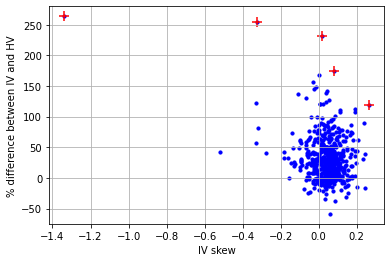

In [89]:
plt.plot()
plt.grid(True)
plt.scatter(sorted_data[:, 0]*-1, sorted_data[:, 1]*-1, color="blue", s=10)
plt.scatter(sorted_data[pareto_idx, 0]*-1, sorted_data[pareto_idx, 1]*-1, color="red", s=100, marker="+")
plt.xlabel("IV skew")
plt.ylabel("% difference between IV and HV")
plt.show()

In [90]:
indices = sorted_data[pareto_idx][:, -1]*-1
indices = np.array([int(i) for i in indices])

In [91]:
np.array(stock_info_with_iv_subset)[indices]

array([[['(TSLA)', 'consumer_cyclical'],
        ['0.2635', '118.91891891891892']],

       [['(MAT)', 'consumer_cyclical'],
        ['0.0824', '174.9084249084249']],

       [['(PSTH)', 'financials'],
        ['0.0192', '232.45614035087723']],

       [['(OPK)', 'healthcare'],
        ['-0.3227', '254.28678397603895']],

       [['(MNKD)', 'healthcare'],
        ['-1.3373', '263.9074074074074']]], dtype='<U25')

# gamma vs delta analysis

In [43]:
def compute_accumulated_delta(n, gamma, delta):
    
    accumulated_delta = n*delta + 0.5*gamma*(n-1)*n
    
    return accumulated_delta

In [147]:
# query 1

n = 10
gamma = 0.1
delta = 0.6

In [148]:
accumulated_delta = compute_accumulated_delta(n, gamma, delta)

In [149]:
print(accumulated_delta)

10.5


In [58]:
# query 2

n = 2
gamma = 0.1
delta = 0.5

In [59]:
accumulated_delta = compute_accumulated_delta(n, gamma, delta)

In [60]:
print(accumulated_delta)

1.0
